In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.4


In [2]:
N_Cls = 10
inDir = '/home/ubuntu/data/dstl/data'
topDir = '/home/ubuntu/data/dstl'
DF = pd.read_csv(inDir + '/train_wkt_v4.csv')
GS = pd.read_csv(inDir + '/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
ISZ = 160
smooth = 1e-12

In [3]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


In [4]:
def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


In [5]:
def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


In [6]:
def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

In [7]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask

In [8]:
def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask

In [9]:

def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


In [10]:
def stretch_n(bands, lower_percent=5, higher_percent=95):
#     out = np.zeros_like(bands)    
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


In [29]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

In [27]:
def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

In [13]:
def stick_all_train():
    print "let's stick all imgs together"
    s = 835

    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, N_Cls))

    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]

            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print np.amax(y), np.amin(y)

#      np.save('data/x_trn_%d' % N_Cls, x)
#      np.save('data/y_trn_%d' % N_Cls, y)

    np.save(inDir + '/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/y_trn_%d' % N_Cls, y)

In [14]:
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    x, y = [], []

    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]

                x.append(im)
                y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


In [15]:
def make_val():
    print "let's pick some samples for validation"
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)
#     img = np.load('data/x_trn_%d.npy' % N_Cls)
#     msk = np.load('data/y_trn_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000)

#     np.save('data/x_tmp_%d' % N_Cls, x)
#     np.save('data/y_tmp_%d' % N_Cls, y)
    
    np.save(inDir + '/x_tmp_%d' % N_Cls, x)
    np.save(inDir + '/y_tmp_%d' % N_Cls, y)
    
    

In [16]:

def get_unet():
    print "build network"
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

In [17]:
def calc_jacc(model):
    img = np.load(inDir + '/x_tmp_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_tmp_%d.npy' % N_Cls)

    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return score, trs


In [18]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


In [19]:

def mask_to_polygons(mask, epsilon=5, min_area=1.):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons



In [20]:
def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min



In [44]:
def train_net():
    print "start train net"
    x_val, y_val = np.load(inDir + '/x_tmp_%d.npy' % N_Cls), np.load(inDir +'/y_tmp_%d.npy' % N_Cls)
   
    img = np.load(inDir + '/x_trn_%d.npy' % N_Cls)
    msk = np.load(inDir + '/y_trn_%d.npy' % N_Cls)

    x_trn, y_trn = get_patches(img, msk)
    print np.ndim(x_trn)
    print np.ndim(y_trn)
    model = get_unet()

#
    model.load_weights(topDir + '/weights/unet_10_jk0.7878')
    model_checkpoint = ModelCheckpoint(topDir + '/weights/unet_tmp.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=10, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights(topDir + '/weights/unet_10_jk%.4f' % score)

    return model

In [45]:
def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]



In [46]:

def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(topDir + '/msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id



In [47]:


def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load(topDir + '/msk/10_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv(topDir + '/subm/1.csv', index=False)


In [48]:
def check_predict(id='6120_2_3'):
    model = get_unet()
    model.load_weights(topDir + '/weights/unet_10_jk0.7878')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(15,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_3')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()



In [ ]:
if __name__ == '__main__':
    stick_all_train()
    make_val()
    model = train_net()
    score, trs = calc_jacc(model)
    predict_test(model, trs)
    make_submit()

    # bonus
    check_predict()


let's stick all imgs together
25
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6010_4_4 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
(837, 848, 8) 6100_1_3 1.0 0.0
(837, 848, 8) 6100_2_2 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_1_2 1.0 0.0
(837, 849, 8) 6110_3_1 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 851, 8) 6120_2_0 1.0 0.0
(837, 851, 8) 6120_2_2 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
(837, 849, 8) 6140_3_1 1.0 0.0
(837, 851, 8) 6150_2_3 1.0 0.0
(837, 848, 8) 6160_2_1 1.0 0.0
(837, 848, 8) 6170_0_4 1.0 0.0
(837, 848, 8) 6170_2_4 1.0 0.0
(837, 848, 8) 6170_4_1 1.0 0.0
1.0 0.0
let's pick some samples for validation
(1052, 8, 160, 160) (1052, 10, 160, 160) 1.0 -1.0 1.0 0.0
start train net
(3458, 8, 160, 160) (3458, 10, 160, 160) 1.0 -1.0 1.0 0.0
4
4
build net

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

Train on 3458 samples, validate on 1052 samples
Epoch 1/10
3458/3458 [==============================] - 364s - loss: 0.0996 - jaccard_coef: 0.1906 - jaccard_coef_int: 0.1906 - acc: 0.9655 - val_loss: 0.0873 - val_jaccard_coef: 0.2369 - val_jaccard_coef_int: 0.2369 - val_acc: 0.9685
Epoch 2/10
3392/3458 [============================>.] - ETA: 6s - loss: 0.0754 - jaccard_coef: 0.2733 - jaccard_coef_int: 0.2733 - acc: 0.9732 

In [33]:
    make_submit()


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...


Self-intersection at or near point 824.0506912442396 342.59447004608296


0


Self-intersection at or near point 194.33333333333334 462
Self-intersection at or near point 287.64406779661016 611.96610169491521
Self-intersection at or near point 388.35425531914893 643.31489361702131
Self-intersection at or near point 772 754
Self-intersection at or near point 774.21006289308173 500.04779874213835
Self-intersection at or near point 180.25 373.16666666666669
Self-intersection at or near point 819.28205128205127 305.64102564102564
Self-intersection at or near point 754.76190476190482 793.3650793650794
Self-intersection at or near point 805.35265700483092 414.22705314009664
Self-intersection at or near point 736.50510204081638 209.71938775510205
Self-intersection at or near point 811.09090909090912 642.30681818181813
Self-intersection at or near point 778.57142857142856 463.42857142857144
Self-intersection at or near point 78.255319148936167 803.57446808510633
Self-intersection at or near point 552.78215767634856 803.96265560165978
Self-intersection at or near point 7

100


Self-intersection at or near point 778 686.33333333333337
Self-intersection at or near point 847.90123456790127 601.27160493827159
Self-intersection at or near point 807.77777777777783 227.66666666666666
Self-intersection at or near point 784.24489795918362 513.96938775510205
Self-intersection at or near point 832.08805031446536 39.276729559748425
Self-intersection at or near point 1.2857142857142858 282.28571428571428
Self-intersection at or near point 674.38461538461536 379
Self-intersection at or near point 736.33333333333337 324
Self-intersection at or near point 301 381
Self-intersection at or near point 575.1204819277109 386.56626506024094
Self-intersection at or near point 718.0625 401.125
Self-intersection at or near point 495.26168224299067 435.98130841121497
Self-intersection at or near point 792.66577540106948 370.72994652406419
Self-intersection at or near point 823 475
Self-intersection at or near point 796.83673469387759 794.2585034013606
Self-intersection at or near poin

200


Self-intersection at or near point 828.59375 552.8125
Self-intersection at or near point 691.03404255319151 316.59148936170214
Self-intersection at or near point 842.42735042735046 304.40170940170941
Self-intersection at or near point 828.88059701492534 600.35820895522386
Self-intersection at or near point 468.0344827586207 37.448275862068968
Self-intersection at or near point 699.28571428571433 174
Self-intersection at or near point 842.68789808917199 602.32484076433116
Self-intersection at or near point 821.957345971564 647.48341232227483
Self-intersection at or near point 781.41584158415844 827.02970297029708
Self-intersection at or near point 468.17213114754099 15.098360655737705
Self-intersection at or near point 145.15671641791045 797.79104477611941
Self-intersection at or near point 819.96938775510205 223.07142857142858
Self-intersection at or near point 787.35971223021579 659.74820143884892
Self-intersection at or near point 732.7037037037037 514.03703703703707
Self-intersectio

300


Self-intersection at or near point 528.81132075471703 789.66037735849056
Self-intersection at or near point 341.30769230769232 642.76923076923072
Self-intersection at or near point 671 136.59090909090909
Self-intersection at or near point 796.88461538461536 373.19230769230768
Self-intersection at or near point 827.37956204379566 437.31751824817519
Self-intersection at or near point 654 141.38095238095238
Self-intersection at or near point 804.99502487562188 343.38142620232173
Self-intersection at or near point 473.58064516129031 321.61290322580646
Self-intersection at or near point 313.58536585365852 159.95121951219511
Self-intersection at or near point 739 394.27272727272725
Self-intersection at or near point 649.5 797.25
Self-intersection at or near point 792.07692307692309 329.84615384615387
Self-intersection at or near point 474.71052631578948 800.18421052631584
Self-intersection at or near point 811.28571428571433 479.89610389610391
Self-intersection at or near point 480.070796460

400


Self-intersection at or near point 722.66666666666663 123.33333333333333
Self-intersection at or near point 826.30927835051546 40.134020618556704
Self-intersection at or near point 764.68354430379748 425.55696202531647
Self-intersection at or near point 185.39361702127658 376.22340425531917
Self-intersection at or near point 724.60000000000002 477.80000000000001
Self-intersection at or near point 837.0612244897959 100.91836734693878
Self-intersection at or near point 790.53658536585363 401.07317073170731
Self-intersection at or near point 779.54692556634302 768.22977346278321
Self-intersection at or near point 16.029268292682929 788.9365853658536
Self-intersection at or near point 781 144.47368421052633
Self-intersection at or near point 841.73356401384081 598.50519031141869
Self-intersection at or near point 742.5414012738853 272.36942675159236
Self-intersection at or near point 744.10465116279067 62.046511627906973
Ring Self-intersection at or near point 292 654
Self-intersection at 

500


Self-intersection at or near point 679 733.77777777777783
Self-intersection at or near point 830.09749303621174 30.233983286908078
Self-intersection at or near point 525.125 779.75
Self-intersection at or near point 794.17857142857144 386.53571428571428
Self-intersection at or near point 830.83425414364638 133.40331491712706
Self-intersection at or near point 831.81632653061229 684.47619047619048
Self-intersection at or near point 808.54285714285709 65.67619047619047
Self-intersection at or near point 808 809.18181818181813
Self-intersection at or near point 818.44444444444446 135
Self-intersection at or near point 652.63636363636363 218.45454545454547
Self-intersection at or near point 795.52863436123346 701.10132158590307
Self-intersection at or near point 800 721
Self-intersection at or near point 577.0514469453376 28.781350482315112
Self-intersection at or near point 746.29239766081866 788.80116959064333
Self-intersection at or near point 743.64081632653063 163.05714285714285
Self-

600


Self-intersection at or near point 768.86238532110087 25.11467889908257
Self-intersection at or near point 789.35849056603774 804.30188679245282
Self-intersection at or near point 787.04907975460128 518.05521472392638
Self-intersection at or near point 820.58076225045374 477.66061705989108
Self-intersection at or near point 796.02531645569616 800.08860759493666
Self-intersection at or near point 651.921875 38.9375
Self-intersection at or near point 809.20689655172418 690.68965517241384
Self-intersection at or near point 486.38636363636363 551.38636363636363
Ring Self-intersection at or near point 632 511
Self-intersection at or near point 38.142857142857146 285.28571428571428
Self-intersection at or near point 678.83719615602035 321.67834934991521
Self-intersection at or near point 324.92857142857144 811.83333333333337
Self-intersection at or near point 591.07142857142856 151.5
Self-intersection at or near point 279.33333333333331 388.66666666666669
Self-intersection at or near point 7

700


Self-intersection at or near point 555.74693877551022 2.7448979591836737
Self-intersection at or near point 663.78181818181815 595.74545454545455
Self-intersection at or near point 105 512.5333333333333
Self-intersection at or near point 189.92561983471074 414.04132231404958
Ring Self-intersection at or near point 159 413
Self-intersection at or near point 469.8692307692308 604.67307692307691
Self-intersection at or near point 251.72392638036808 31.030674846625768
Self-intersection at or near point 804.44444444444446 80.888888888888886
Self-intersection at or near point 30.172786177105831 481.19438444924407
Self-intersection at or near point 773.07284768211923 203.12582781456953
Self-intersection at or near point 668.8648648648649 186.24324324324326
Self-intersection at or near point 382.63285556780596 831.60418963616314
Self-intersection at or near point 457.5 435.5
Self-intersection at or near point 698.13636363636363 817.22727272727275
Self-intersection at or near point 847.23076923

800


Self-intersection at or near point 20 693.15384615384619
Self-intersection at or near point 812.11153846153843 163.66923076923078
Self-intersection at or near point 733.16923076923081 157.67692307692309
Self-intersection at or near point 616.48689138576776 625.5355805243446
Ring Self-intersection at or near point 421 99
Self-intersection at or near point 597.91836734693879 17.959183673469386
Self-intersection at or near point 190 775.5454545454545
Self-intersection at or near point 654.07692307692309 273.73076923076923
Self-intersection at or near point 692.11640211640213 149.28042328042329
Self-intersection at or near point 782.34883720930236 164.30232558139534
Self-intersection at or near point 812.5 94.5
Self-intersection at or near point 726.03731343283584 668.7388059701492
Self-intersection at or near point 681.39285714285711 109.85714285714286
Self-intersection at or near point 313.39999999999998 658.60000000000002
Self-intersection at or near point 72 773
Self-intersection at or

900


Self-intersection at or near point 814.38461538461536 642.92307692307691
Self-intersection at or near point 801.85714285714289 80.285714285714292
Self-intersection at or near point 757.39097744360902 704.48872180451133
Self-intersection at or near point 730.13043478260875 774
Self-intersection at or near point 671.26016260162601 560.83739837398377
Self-intersection at or near point 843.63963963963965 37.549549549549553
Self-intersection at or near point 674.02127659574467 473.68085106382978
Self-intersection at or near point 529.78947368421052 260.78947368421052
Self-intersection at or near point 263.03422053231941 575.11406844106466
Self-intersection at or near point 787.14999999999998 472.69999999999999
Ring Self-intersection at or near point 827 517
Self-intersection at or near point 777.77419354838707 570.58064516129036
Self-intersection at or near point 800.47619047619048 296.47619047619048
Self-intersection at or near point 196.58823529411765 143
Self-intersection at or near poin

1000


Self-intersection at or near point 805.54298642533934 768.95927601809956
Self-intersection at or near point 323.95652173913044 210.33913043478262
Self-intersection at or near point 787.49275362318838 260.08695652173913
Self-intersection at or near point 627 800
Self-intersection at or near point 12.056603773584905 39.037735849056602
Self-intersection at or near point 645.1416309012875 85.115879828326186
Self-intersection at or near point 534.11583011583014 812.32432432432438
Self-intersection at or near point 798.03759398496243 803.73684210526312
Self-intersection at or near point 818.90082644628103 419.26446280991735
Self-intersection at or near point 625.14285714285711 341.71428571428572
Self-intersection at or near point 846.43902439024396 724.6260162601626
Self-intersection at or near point 444.53846153846155 594.46153846153845
Self-intersection at or near point 725.27272727272725 637.22314049586782
Self-intersection at or near point 762.30769230769226 782.92307692307691
Self-inter

1100


Self-intersection at or near point 2.4615384615384617 26
Self-intersection at or near point 343 179
Self-intersection at or near point 623.82769230769236 172.3753846153846
Self-intersection at or near point 470.55893536121675 69.091254752851711
Self-intersection at or near point 751.51612903225805 167.07526881720429
Self-intersection at or near point 599.39800995024871 222.05472636815921
Self-intersection at or near point 153.70260223048328 155.02230483271376
Self-intersection at or near point 708.93396226415098 172.27358490566039
Self-intersection at or near point 637.96676737160124 800.11480362537759
Self-intersection at or near point 564.33788395904435 752.96928327645048
Self-intersection at or near point 667.08695652173913 237.08695652173913
Ring Self-intersection at or near point 813 480
Self-intersection at or near point 726.12716763005778 653.96531791907512
Self-intersection at or near point 639.3373493975904 89.963855421686745
Self-intersection at or near point 655 836
Self-int

1200


Self-intersection at or near point 193.41176470588235 225.29411764705881
Self-intersection at or near point 645.16666666666663 808.91666666666663
Self-intersection at or near point 121.82142857142857 230.17857142857142
Self-intersection at or near point 808.86666666666667 14.066666666666666
Self-intersection at or near point 417.62162162162161 332.72972972972974
Self-intersection at or near point 443.8173515981735 492.52511415525112
Self-intersection at or near point 402.72972972972974 247.43243243243242
Self-intersection at or near point 720.27272727272725 624.09090909090912
Self-intersection at or near point 814.375 123.25
Self-intersection at or near point 776.07913669064749 790.06474820143887
Self-intersection at or near point 709.30923694779119 673.25301204819277
Self-intersection at or near point 178.46808510638297 281.02127659574467
Self-intersection at or near point 579 744
Self-intersection at or near point 564.61855670103091 709.32989690721649
Self-intersection at or near poi

1300


Self-intersection at or near point 802.89020270270271 481.92145270270271
Self-intersection at or near point 318.92556634304208 829.01618122977345
Self-intersection at or near point 718.08888888888885 822.93333333333328
Self-intersection at or near point 309.39603960396039 320.43564356435644
Ring Self-intersection at or near point 320 499
Self-intersection at or near point 516.69767441860461 730.11627906976742
Self-intersection at or near point 398.05000000000001 230.69999999999999
Self-intersection at or near point 811.03076923076924 750.89743589743591
Self-intersection at or near point 714.32869080779949 636.02228412256272
Self-intersection at or near point 716.95555555555552 457.0888888888889
Self-intersection at or near point 30.25 72.625
Self-intersection at or near point 781.86538461538464 713.80769230769226
Self-intersection at or near point 157.94814814814814 93.007407407407413
Self-intersection at or near point 482.75 289.25
Self-intersection at or near point 480 769
Self-inter

1400


Self-intersection at or near point 710.13043478260875 350.30434782608694
Self-intersection at or near point 689.15189873417717 367.22784810126581
Self-intersection at or near point 668.51923076923072 597.76923076923072
Self-intersection at or near point 181 392
Self-intersection at or near point 152.85714285714286 267.57142857142856
Self-intersection at or near point 784.35668789808915 296.84713375796179
Self-intersection at or near point 284.52173913043481 273.56521739130437
Self-intersection at or near point 609.29508196721315 72.180327868852459
Self-intersection at or near point 629.45714285714291 147.51428571428571
Self-intersection at or near point 642.79245283018872 606.23899371069183
Self-intersection at or near point 480.02158273381298 638.51798561151077
Self-intersection at or near point 794.42222222222222 603.86666666666667
Self-intersection at or near point 810.80094786729853 158.66824644549763
Self-intersection at or near point 808.15625 210.4375
Self-intersection at or nea

1500


Self-intersection at or near point 766.69767441860461 836.30232558139539
Self-intersection at or near point 476.64556962025318 170.02531645569621
Self-intersection at or near point 322.88 21.66
Self-intersection at or near point 755.2696629213483 57.044943820224717
Self-intersection at or near point 811.00797448165872 2.0287081339712918
Self-intersection at or near point 785.75285171102666 312.04182509505705
Self-intersection at or near point 714.32352941176475 827.32352941176475
Self-intersection at or near point 756.24242424242425 549.78787878787875
Self-intersection at or near point 2.4070450097847358 17.436399217221137
Self-intersection at or near point 805.10810810810813 204.08108108108109
Self-intersection at or near point 806.14400000000001 608.72799999999995
Self-intersection at or near point 196 798
Self-intersection at or near point 797.10526315789468 448.89473684210526
Self-intersection at or near point 834 223
Self-intersection at or near point 819.06185567010311 144.762886

1600


Self-intersection at or near point 816.80952380952385 646.19047619047615
Self-intersection at or near point 795.86298076923072 822.97115384615381
Self-intersection at or near point 399.64705882352939 183.64705882352942
Self-intersection at or near point 434.67029972752044 340.85013623978199
Self-intersection at or near point 537.04132231404958 205.099173553719
Self-intersection at or near point 64.333333333333329 37
Self-intersection at or near point 641.5333333333333 437.73333333333335
Self-intersection at or near point 448.60194174757282 591.93203883495141
Self-intersection at or near point 625.05154639175259 426.22886597938145
Self-intersection at or near point 599.66666666666663 175.66666666666666
Self-intersection at or near point 618.14545454545453 45.554545454545455
Self-intersection at or near point 703.66666666666663 204.33333333333334
Ring Self-intersection at or near point 764 792
Self-intersection at or near point 637.37423312883436 692.1625766871166
Self-intersection at or

1700


Self-intersection at or near point 712.51999999999998 117.23999999999999
Self-intersection at or near point 199.31578947368422 708.02631578947364
Self-intersection at or near point 381 760
Self-intersection at or near point 691.56164383561645 67.956947162426616
Self-intersection at or near point 678.96116504854365 527.82524271844659
Self-intersection at or near point 159.71428571428572 689.42857142857144
Ring Self-intersection at or near point 116 821
Self-intersection at or near point 663.09230769230771 244.59999999999999
Self-intersection at or near point 279.95774647887322 833.52112676056333
Self-intersection at or near point 684.44444444444446 613.55555555555554
Self-intersection at or near point 840.19512195121956 321.34146341463412
Self-intersection at or near point 638.63829787234044 381.82978723404256
Self-intersection at or near point 333.7748344370861 423.17218543046357
Self-intersection at or near point 800.063829787234 226.04255319148936
Self-intersection at or near point 8

1800


Self-intersection at or near point 788.78571428571433 571.78571428571433
Self-intersection at or near point 803.71181556195961 573.67146974063405
Self-intersection at or near point 814.22699386503064 162.32515337423314
Self-intersection at or near point 45.545454545454547 119.81818181818181
Self-intersection at or near point 817.16666666666663 129
Self-intersection at or near point 749.06884681583472 158.24268502581756
Self-intersection at or near point 805.76728499156832 347.84148397976389
Self-intersection at or near point 842.88100686498854 284.50800915331808
Self-intersection at or near point 838.61290322580646 127.58064516129032
Self-intersection at or near point 301.78260869565219 806.73913043478262
Self-intersection at or near point 719.65340909090912 300.26136363636363
Self-intersection at or near point 482.96306068601581 597.24538258575194
Self-intersection at or near point 145.37323943661971 718.18309859154931
Self-intersection at or near point 843.5175879396985 820.115577889

1900


Self-intersection at or near point 449.78947368421052 190.89473684210526
Self-intersection at or near point 252.12980769230768 335.32211538461536
Self-intersection at or near point 492.28057553956836 638.34532374100718
Self-intersection at or near point 703.30769230769226 515.61538461538464
Self-intersection at or near point 307.83928571428572 484.42857142857144
Self-intersection at or near point 402.97066014669929 296.16625916870413
Self-intersection at or near point 319 633.89473684210532
Self-intersection at or near point 82.091872791519435 182.0565371024735
Self-intersection at or near point 723.95876288659792 161.24742268041237
Self-intersection at or near point 779.35714285714289 701.71428571428567
Self-intersection at or near point 723.90909090909088 791.84415584415581
Self-intersection at or near point 677.14035087719299 11.754385964912281
Self-intersection at or near point 718 792.75
Self-intersection at or near point 797.60227272727275 469.44318181818181
Self-intersection at 

2000


Self-intersection at or near point 795.02479338842977 801.10743801652893
Self-intersection at or near point 633.71428571428567 502.28571428571428
Self-intersection at or near point 734.70212765957444 619.531914893617
Self-intersection at or near point 846.24786324786328 264.71794871794873
Self-intersection at or near point 811 212.33333333333334
Self-intersection at or near point 596.17307692307691 445.77884615384613
Self-intersection at or near point 643.40597014925368 370.70447761194032
Self-intersection at or near point 731.50837988826811 389.32960893854749
Self-intersection at or near point 501.25 816.125
Self-intersection at or near point 753.15384615384619 491.13461538461536
Self-intersection at or near point 40 836
Self-intersection at or near point 815.51724137931035 395.41379310344826
Self-intersection at or near point 828.51048951048949 449.29370629370629
Self-intersection at or near point 814.85788113695094 401.16795865633077
Self-intersection at or near point 602.5652173913

2100


Self-intersection at or near point 792.55862068965519 417.72413793103448
Self-intersection at or near point 659.80645161290317 297.87096774193549
Self-intersection at or near point 764.66796875 835.62890625
Self-intersection at or near point 792.25 445.0625
Ring Self-intersection at or near point 845 697
Self-intersection at or near point 785.16129032258061 616.83870967741939
Self-intersection at or near point 801.82894736842104 612.86184210526312
Self-intersection at or near point 711.91566265060237 23.309236947791163
Self-intersection at or near point 88.062052505966591 2.8353221957040571
Self-intersection at or near point 707.15044247787614 13.097345132743364
Self-intersection at or near point 728.08759124087589 640.70072992700727
Self-intersection at or near point 538.64561734213009 830.28840716305376
Self-intersection at or near point 222.07250755287009 571.23564954682774
Self-intersection at or near point 785.21739130434787 354.26086956521738
Self-intersection at or near point 68

2200


Self-intersection at or near point 777 643.66666666666663
Self-intersection at or near point 829.21428571428567 678.21428571428567
Self-intersection at or near point 802.98130841121497 594.35514018691583
Self-intersection at or near point 737.75862068965512 447.44827586206895
Self-intersection at or near point 803.13253012048187 374.46987951807228
Self-intersection at or near point 552.38636363636363 694.61363636363637
Self-intersection at or near point 745.984375 160.125
Self-intersection at or near point 604.64516129032256 638.35483870967744
Self-intersection at or near point 815.53846153846155 479.46153846153845
Self-intersection at or near point 748.23025210084029 240.71764705882353
Self-intersection at or near point 685.5 638
Self-intersection at or near point 532.14666666666665 244.06666666666666
Self-intersection at or near point 685.10526315789468 446.21052631578948
Self-intersection at or near point 417.36437246963561 702.48987854251016
Self-intersection at or near point 562.4

2300


Self-intersection at or near point 362.37837837837839 289.27027027027026
Self-intersection at or near point 590.10752688172045 798.17204301075265
Self-intersection at or near point 800.68852459016398 417.34426229508199
Self-intersection at or near point 785.48387096774195 636.87096774193549
Self-intersection at or near point 798.7560975609756 51.097560975609753
Self-intersection at or near point 236.56 637.35428571428577
Self-intersection at or near point 765.99065420560748 799.9439252336449
Self-intersection at or near point 664.25641025641028 833.46438746438741
Self-intersection at or near point 743.42657342657344 565.22377622377621
Self-intersection at or near point 764.25711481844951 833.4857703631011
Self-intersection at or near point 652.40601503759399 24.766917293233082
Self-intersection at or near point 365.24444444444447 347.93333333333334
Self-intersection at or near point 687 459
Self-intersection at or near point 49.421052631578945 749.68421052631584
Self-intersection at or

2400


Self-intersection at or near point 795.63636363636363 16.272727272727273
Self-intersection at or near point 845.18181818181813 377.45454545454544
Self-intersection at or near point 291.5 461.875
Self-intersection at or near point 760.75862068965512 685.06896551724139
Self-intersection at or near point 844.22033898305085 134.28813559322035
Self-intersection at or near point 778.40740740740739 799.07037037037037
Self-intersection at or near point 838.44686648501363 37.408719346049047
Self-intersection at or near point 809.78048780487802 279.34146341463412
Self-intersection at or near point 816.84982935153585 3.4129692832764507
Self-intersection at or near point 82.808118081180808 126.32472324723247
Self-intersection at or near point 615.53846153846155 112
Self-intersection at or near point 321.30434782608694 171.47826086956522
Self-intersection at or near point 756.68627450980387 499.50980392156862
Self-intersection at or near point 649.786350148368 477.81305637982194
Self-intersection a

2500


Self-intersection at or near point 808.33196721311481 381.90983606557376
Self-intersection at or near point 617.17808219178085 819.16438356164383
Self-intersection at or near point 793.57446808510633 344.61702127659572
Self-intersection at or near point 824.66666666666663 301.66666666666669
Self-intersection at or near point 259.25641025641028 87.230769230769226
Self-intersection at or near point 741.93237704918033 142.13729508196721
Self-intersection at or near point 340.33333333333331 139
Self-intersection at or near point 203.21492537313432 322.78805970149256
Self-intersection at or near point 823.36363636363637 402.77272727272725
Self-intersection at or near point 561.37037037037032 32.246913580246911
Self-intersection at or near point 747.7538461538461 79.574358974358972
Ring Self-intersection at or near point 640 93
Self-intersection at or near point 703.52941176470586 97.764705882352942
Self-intersection at or near point 706.20930232558135 457.04651162790697
Self-intersection at

2600


Self-intersection at or near point 697.30364372469637 772.9878542510121
Self-intersection at or near point 763.02439024390242 86.390243902439025
Self-intersection at or near point 368.19642857142856 537.41071428571433
Self-intersection at or near point 269.51020408163265 581.69387755102036
Self-intersection at or near point 11.302670623145401 835.60830860534122
Self-intersection at or near point 734.59459459459458 318.19819819819821
Self-intersection at or near point 640.1232876712329 636.71232876712327
Self-intersection at or near point 808.03125 323.96875
Self-intersection at or near point 813.54736842105262 261.34385964912281
Self-intersection at or near point 481.91891891891891 600.40540540540542
Self-intersection at or near point 849.12016293279021 108.5112016293279
Self-intersection at or near point 675.27272727272725 525.31818181818187
Self-intersection at or near point 810.50400000000002 366.06400000000002
Self-intersection at or near point 497.23809523809524 637.76190476190482

2700


Self-intersection at or near point 687.29230769230765 581.81538461538457
Self-intersection at or near point 475.29310344827587 482.19827586206895
Self-intersection at or near point 747.57142857142856 201.12244897959184
Ring Self-intersection at or near point 177 571
Self-intersection at or near point 224.57142857142858 100
Self-intersection at or near point 251.75490196078431 56.803921568627452
Self-intersection at or near point 766.00985221674875 228.12807881773398
Self-intersection at or near point 689.84615384615381 73
Self-intersection at or near point 22.969581749049429 453.28517110266159
Self-intersection at or near point 641.52127659574467 40.468085106382979
Self-intersection at or near point 171.5 551
Self-intersection at or near point 791.5454545454545 268.63636363636363
Self-intersection at or near point 827.44796380090497 197.45248868778282
Self-intersection at or near point 712.87610619469024 216.61061946902655
Self-intersection at or near point 801.61470588235295 765.10294

2800


Self-intersection at or near point 705.27777777777783 208.7685185185185
Self-intersection at or near point 838.0114942528736 340.10344827586209
Self-intersection at or near point 814.61818181818182 606.31818181818187
Self-intersection at or near point 482.38732394366195 603.85915492957747
Self-intersection at or near point 812.76595744680856 32.872340425531917
Self-intersection at or near point 463.26153846153846 151.09230769230768
Self-intersection at or near point 759.94117647058829 496.14705882352939
Self-intersection at or near point 837.02970297029708 410.79207920792078
Self-intersection at or near point 307 353.66666666666669
Self-intersection at or near point 814.82524271844659 747.01941747572812
Self-intersection at or near point 458.30034129692831 641.13651877133111
Self-intersection at or near point 800.61904761904759 1.8571428571428572
Self-intersection at or near point 800 296.75
Self-intersection at or near point 806.70000000000005 422.51428571428573
Self-intersection at o

2900


Self-intersection at or near point 381.3984375 48.4375
Self-intersection at or near point 592.1512195121951 540.44390243902444
Self-intersection at or near point 796.43153526970957 670.12033195020751
Self-intersection at or near point 160.41984732824429 447.3358778625954
Ring Self-intersection at or near point 808 638
Self-intersection at or near point 685.18181818181813 618.93939393939399
Self-intersection at or near point 550.10000000000002 356.69999999999999
Self-intersection at or near point 802.16470588235291 741.30196078431368
Self-intersection at or near point 626.55357142857144 482.8125
Self-intersection at or near point 776.25157232704407 314.20125786163521
Self-intersection at or near point 846.08527131782944 618.08527131782944
Self-intersection at or near point 672.25581395348843 447.75968992248062
Self-intersection at or near point 821.46153846153845 236.28846153846155
Self-intersection at or near point 796.74157303370782 10.426966292134832
Self-intersection at or near poin

3000


Self-intersection at or near point 733.1875 420.58333333333331
Self-intersection at or near point 839.49275362318838 92.710144927536234
Self-intersection at or near point 775.11940298507466 750.66417910447763
Self-intersection at or near point 67.438596491228068 157.45614035087721
Self-intersection at or near point 554.51724137931035 533.51724137931035
Self-intersection at or near point 845.06635071090045 735.3175355450237
Self-intersection at or near point 823.50806451612902 269.83870967741933
Self-intersection at or near point 352.0563697857948 320.23675310033821
Self-intersection at or near point 842.77272727272725 226.48863636363637
Self-intersection at or near point 846.28994082840234 118.69822485207101
Self-intersection at or near point 391.62576687116564 366.26993865030676
Self-intersection at or near point 578.06862745098044 587.23529411764707
Self-intersection at or near point 750.87209302325584 324.69767441860466
Self-intersection at or near point 788.57142857142856 480.08928

3100


Self-intersection at or near point 336.45161290322579 690.41935483870964
Self-intersection at or near point 781.33783783783781 203.40540540540542
Self-intersection at or near point 800 804
Self-intersection at or near point 330.12101910828028 830.82165605095543
Self-intersection at or near point 833.68292682926824 486.0569105691057
Self-intersection at or near point 845.7731958762887 511.18556701030928
Self-intersection at or near point 799.928 356.36000000000001
Self-intersection at or near point 349.92631578947368 10.610526315789473
Self-intersection at or near point 327.77486910994764 287.24607329842934
Self-intersection at or near point 535 636.9655172413793
Self-intersection at or near point 685 50
Ring Self-intersection at or near point 456 747
Self-intersection at or near point 671.82608695652175 642.82608695652175
Self-intersection at or near point 658.03846153846155 552.34615384615381
Self-intersection at or near point 606.34645669291342 20.212598425196852
Self-intersection at

3200


Self-intersection at or near point 766.61111111111109 299.27777777777777
Self-intersection at or near point 818.45614035087715 609.61403508771934
Self-intersection at or near point 695.69298245614038 763.78070175438597
Self-intersection at or near point 806.37777777777774 467.35555555555555
Self-intersection at or near point 790.38144329896909 755.74226804123714
Self-intersection at or near point 800.53475177304961 512.34184397163119
Self-intersection at or near point 728.14029850746272 517.86268656716413
Self-intersection at or near point 800.32450832072618 562.09984871406959
Self-intersection at or near point 431 655
Ring Self-intersection at or near point 325 793
Self-intersection at or near point 843.96000000000004 156.36000000000001
Self-intersection at or near point 777.56363636363642 745.5090909090909
Self-intersection at or near point 366.25324675324674 194.35064935064935
Self-intersection at or near point 796.768115942029 360.68115942028987
Self-intersection at or near point 1

3300


Self-intersection at or near point 740 409.55555555555554
Self-intersection at or near point 833.35057471264372 226.84482758620689
Self-intersection at or near point 768.38181818181818 648.41818181818178
Self-intersection at or near point 839.74545454545455 325.35000000000002
Self-intersection at or near point 778.14754098360652 792.59016393442619
Self-intersection at or near point 620.42424242424238 787.5151515151515
Self-intersection at or near point 635 87.111111111111114
Self-intersection at or near point 637.93548387096769 619.08064516129036
Self-intersection at or near point 280.45685279187819 811.05076142131975
Self-intersection at or near point 400.07594936708858 834.96202531645565
Self-intersection at or near point 70.547169811320757 809.35849056603774
Self-intersection at or near point 739.7429805615551 581.93952483801297
Self-intersection at or near point 517 836
Self-intersection at or near point 725.5336322869955 60.439461883408072
Self-intersection at or near point 802.25

3400


Self-intersection at or near point 253.03667481662592 547.73105134474326
Self-intersection at or near point 347.03603603603602 547.61261261261257
Self-intersection at or near point 800.40487804878046 40.424390243902437
Self-intersection at or near point 644.296875 81.25
Self-intersection at or near point 796.92857142857144 64.678571428571431
Self-intersection at or near point 360.77777777777777 265.88888888888891
Self-intersection at or near point 168.67088607594937 544.37341772151899
Self-intersection at or near point 694.23004694835686 469.44366197183098
Self-intersection at or near point 692.43689320388353 131.19417475728156
Self-intersection at or near point 823.67816091954023 170.60919540229884
Self-intersection at or near point 841.72602739726028 800.2465753424658
Self-intersection at or near point 788 299.33333333333331
Self-intersection at or near point 634.43478260869563 468.69565217391306
Self-intersection at or near point 494.32499999999999 37.075000000000003
Self-intersecti

3500


Self-intersection at or near point 705.44000000000005 153.28
Self-intersection at or near point 786.09638554216872 504.72289156626505
Self-intersection at or near point 647.03846153846155 835.19230769230774
Self-intersection at or near point 633.77279752704794 532.27897990726433
Self-intersection at or near point 677.25 564
Self-intersection at or near point 571.7795414462081 834.58024691358025
Self-intersection at or near point 436.83263598326357 112.14225941422595
Self-intersection at or near point 371.40625 188.375
Self-intersection at or near point 675.2658227848101 631.54430379746839
Self-intersection at or near point 208.47368421052633 817.68421052631584
Self-intersection at or near point 791.28571428571433 691.57142857142856
Self-intersection at or near point 697.3125 368.125
Self-intersection at or near point 237.06060606060606 9.7272727272727266
Self-intersection at or near point 593.04499999999996 274.93000000000001
Self-intersection at or near point 614.77777777777783 72.777

3600


Self-intersection at or near point 671.44525547445255 278.54014598540147
Self-intersection at or near point 563.6044776119403 735.87313432835822
Self-intersection at or near point 161.41453566621803 463.77792732166893
Self-intersection at or near point 746.65346534653463 501.23762376237624
Self-intersection at or near point 499.73913043478262 480.08695652173913
Self-intersection at or near point 160.00638964876899 318.49841257163393
Self-intersection at or near point 511 576.13793103448279
Self-intersection at or near point 714.95384615384614 669.98461538461538
Self-intersection at or near point 476.69325153374234 179.22494887525562
Self-intersection at or near point 712.78417266187046 510.97841726618702
Self-intersection at or near point 763.86607142857144 552.6875
Self-intersection at or near point 666.62337662337666 15.142857142857142
Self-intersection at or near point 665.05063291139243 407.45569620253167
Self-intersection at or near point 785.07482993197277 604.42176870748301
Self

3700


Self-intersection at or near point 643.10725552050474 234.09463722397476
Self-intersection at or near point 787.62893081761001 738.63522012578619
Self-intersection at or near point 770.02702702702697 641.37837837837833
Self-intersection at or near point 806.24193548387098 236.85483870967741
Self-intersection at or near point 434.69339622641508 638.04245283018872
Self-intersection at or near point 602.13157894736844 10.601973684210526
Self-intersection at or near point 346.03550295857985 798.44378698224853
Self-intersection at or near point 645.46318289786223 223.96437054631829
Self-intersection at or near point 806.60591133004925 777.53201970443354
Self-intersection at or near point 387 788
Self-intersection at or near point 76 320
Self-intersection at or near point 799 199.11764705882354
Ring Self-intersection at or near point 252 365
Self-intersection at or near point 314.09947643979058 287.27225130890054
Self-intersection at or near point 635.90909090909088 106.36363636363636
Self-i

3800


Self-intersection at or near point 797 134
Self-intersection at or near point 802.49710982658962 821.3121387283237
Self-intersection at or near point 532 836
Self-intersection at or near point 726.97938144329896 326.92783505154637
Self-intersection at or near point 774.5 238.5
Ring Self-intersection at or near point 799 765
Self-intersection at or near point 768.02803738317755 90.887850467289724
Self-intersection at or near point 159.59259259259258 429.2962962962963
Self-intersection at or near point 178.30324400564174 326.15232722143867
Self-intersection at or near point 478.72602739726028 220.83561643835617
Self-intersection at or near point 543.08823529411768 500.99019607843138
Self-intersection at or near point 791.04132231404958 276.77685950413223
Self-intersection at or near point 760.0151515151515 455.93939393939394
Self-intersection at or near point 714.31531531531527 488.7837837837838
Self-intersection at or near point 770.47540983606552 560.70491803278685
Self-intersection at

3900


Self-intersection at or near point 843.44009779951102 94.464547677261606
Self-intersection at or near point 840.39999999999998 617.39999999999998
Self-intersection at or near point 836.61111111111109 200
Self-intersection at or near point 838.304347826087 451.47826086956519
Self-intersection at or near point 729.89473684210532 31.368421052631579
Self-intersection at or near point 798.58715596330273 819.04587155963304
Self-intersection at or near point 799 131.61904761904762
Self-intersection at or near point 800.5151515151515 627.93939393939399
Self-intersection at or near point 844.14285714285711 449.14285714285717
Self-intersection at or near point 239.68421052631578 595.44019138755982
Self-intersection at or near point 816.08280254777071 481.40764331210192
Self-intersection at or near point 826.21649484536078 174.97938144329896
Self-intersection at or near point 677.06235565819861 431.11085450346422
Self-intersection at or near point 659.10526315789468 702.66666666666663
Self-inters

4000


Self-intersection at or near point 777.74050632911394 400.46202531645571
Self-intersection at or near point 791.15999999999997 82.813333333333333
Self-intersection at or near point 610 155.65384615384616
Self-intersection at or near point 477.86046511627904 38.95348837209302
Self-intersection at or near point 802.35416666666663 539.98611111111109
Self-intersection at or near point 801.96621621621625 383.61486486486484
Self-intersection at or near point 838.92307692307691 51.384615384615387
Self-intersection at or near point 321.11111111111109 271.88888888888891
Self-intersection at or near point 633.76842105263154 751.65263157894742
Self-intersection at or near point 796.60000000000002 468.39999999999998
Self-intersection at or near point 281.22891566265059 764.91566265060237
Self-intersection at or near point 224 747.5
Self-intersection at or near point 676 146.125
Self-intersection at or near point 711.01244813278004 1.0788381742738589
Self-intersection at or near point 728.823529411

4100


Self-intersection at or near point 377.38461538461536 529.84615384615381
Self-intersection at or near point 151.12950296397628 831.18695850433198
Self-intersection at or near point 109.48 486.16000000000003
Self-intersection at or near point 611.23834196891187 773.03108808290153
Self-intersection at or near point 640.47058823529414 370.47058823529414
Self-intersection at or near point 792.31818181818187 420.04545454545456
Self-intersection at or near point 765.44827586206895 325.34482758620692
Ring Self-intersection at or near point 309 711
Self-intersection at or near point 388 803
Self-intersection at or near point 633.73109243697479 52.621848739495796
Self-intersection at or near point 795.20796460176996 80.329646017699119
Self-intersection at or near point 479.83999999999997 659.85333333333335
Self-intersection at or near point 791 150
Ring Self-intersection at or near point 847 380
Self-intersection at or near point 826.06271777003485 741.17770034843204
Self-intersection at or nea

4200


Self-intersection at or near point 780.10746812386162 5.2695810564663024
Self-intersection at or near point 31.94142259414226 360.13389121338912
Self-intersection at or near point 834.64285714285711 658.5
Self-intersection at or near point 664.125 45.5
Self-intersection at or near point 48.5 508.14285714285717
Self-intersection at or near point 440.32530120481925 185.56626506024097
Self-intersection at or near point 803.063829787234 263.19148936170211
Self-intersection at or near point 833.88235294117646 510.47058823529414
Self-intersection at or near point 705.9473684210526 250.78947368421052
Self-intersection at or near point 705.33333333333337 108.16666666666667
Self-intersection at or near point 698.02967788635544 834.77741585233446
Self-intersection at or near point 350.61111111111109 281.5
Self-intersection at or near point 679.40851063829791 323.95744680851061
Self-intersection at or near point 741.71428571428567 335.85714285714283
Self-intersection at or near point 307.98263027

    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  MULTIPOLYGON (((0.0061163830238859 -0.00727740...
1  6120_2_4          2  MULTIPOLYGON (((0.0022300440759655 -0.00814247...
2  6120_2_4          3  MULTIPOLYGON (((0.0034100188540249 -0.00753692...
3  6120_2_4          4  MULTIPOLYGON (((0.0022516949893244 -0.00808840...
4  6120_2_4          5  MULTIPOLYGON (((0.0091042090674125 -0.00532018...


build network


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  del sys.

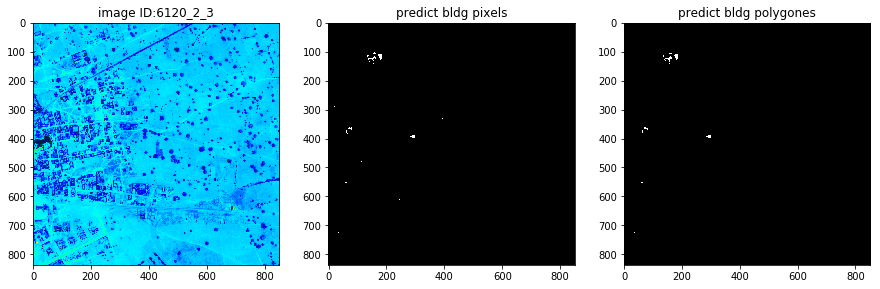

In [39]:

    # bonus
check_predict()